Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv


*   Использовать пайплайны
*   Выполнить поиск лучших параметров
*   Кроссвалидация
*   Сохранить и загрузить модель








In [42]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV




In [2]:
df_walmart=files.upload()

Saving Walmart.csv to Walmart.csv


In [4]:
df=pd.read_csv('Walmart.csv')

In [6]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
df.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


Text(0.5, 1.0, 'Weekly_Sales')

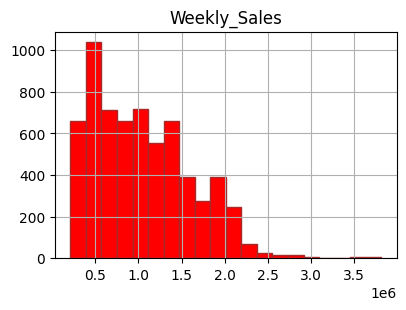

In [9]:
# Устанавливаем размер графиков
plt.figure(figsize=(15, 10))

# Гистограмма для столбца 'Weekly_Sales'
plt.subplot(3, 3, 4)
df['Weekly_Sales'].hist(bins=20, color='red', edgecolor='brown')
plt.title('Weekly_Sales')

In [10]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


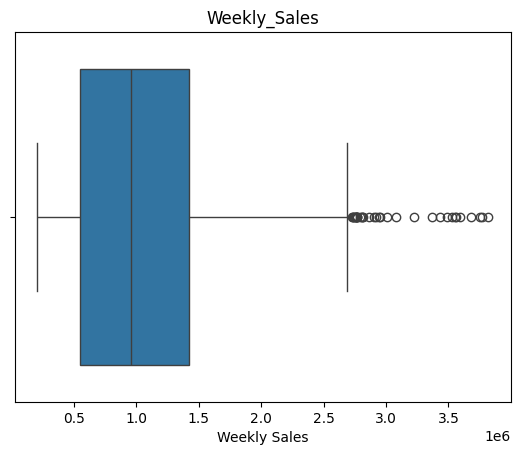

In [13]:
# Строим бокс-плот с помощью Seaborn
sns.boxplot(x=df['Weekly_Sales'])

# Добавляем название графика и осей
plt.title('Weekly_Sales')
plt.xlabel('Weekly Sales')

# Показываем график
plt.show()

In [21]:
#Разобьем дату на день денели, порядковый номер месяца и год, получим 3 дополнительных столбца

# Преобразовываем столбец 'Date' в формат datetime
df['Date'] = pd.to_datetime(df['Date'])

# Добавляем новые столбцы для порядкового месяца, порядкового номера дня недели и года
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday + 1  # Понедельник - 1, Вторник - 2, ...
df['Year'] = df['Date'].dt.year

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Weekday,Year
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,5,7,2010
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,12,4,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,5,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,5,2010
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,5,1,2010


In [20]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Month           0
Weekday         0
Year            0
dtype: int64

In [26]:
# Рассчет корреляции Пирсона
correlation_matrix = df.corr(method='pearson')

# Вывод матрицы корреляции
print(correlation_matrix)

                     Store  Weekly_Sales  Holiday_Flag  Temperature  \
Store         1.000000e+00     -0.335332 -4.386841e-16    -0.022659   
Weekly_Sales -3.353320e-01      1.000000  3.689097e-02    -0.063810   
Holiday_Flag -4.386841e-16      0.036891  1.000000e+00    -0.155091   
Temperature  -2.265908e-02     -0.063810 -1.550913e-01     1.000000   
Fuel_Price    6.002295e-02      0.009464 -7.834652e-02     0.144982   
CPI          -2.094919e-01     -0.072634 -2.162091e-03     0.176888   
Unemployment  2.235313e-01     -0.106176  1.096028e-02     0.101158   
Month         6.289676e-16      0.067535  3.322341e-01     0.066440   
Weekday       2.111522e-15     -0.021041 -9.100474e-02     0.018331   
Year          3.474318e-12     -0.018378 -5.678257e-02     0.064269   

              Fuel_Price       CPI  Unemployment         Month       Weekday  \
Store           0.060023 -0.209492      0.223531  6.289676e-16  2.111522e-15   
Weekly_Sales    0.009464 -0.072634     -0.106176  6.753523

<ipython-input-26-c837aa6d0f7e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


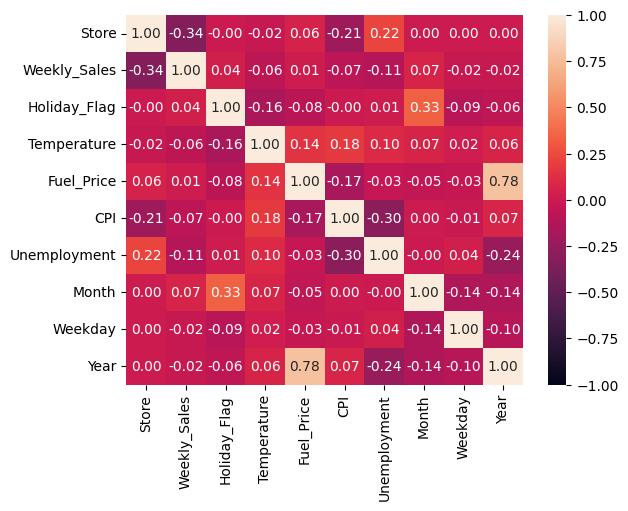

In [27]:
# Построение тепловой карты
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f")
#annot=True аннотации с числовыми значениями, fmt=".2f" форматирует числа с двумя знаками после запятой

plt.show()

In [34]:
X = df.drop(['Weekly_Sales', 'Date'], axis=1) #берем все фичи за исключением целевой и столбца с датой
y = df['Weekly_Sales']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.model_selection import KFold
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),            # Шаг 1: Масштабирование данных
    ('model', RandomForestRegressor())       # Шаг 2: Моделирование RandomForest
])

# Определение параметров для поиска
param_grid = {
    'model__n_estimators': [50, 100, 200],   #Количество деревьев в лесу
    'model__max_depth': [None, 10, 20],      #Максимальная глубина каждого дерева
    'model__min_samples_split': [2, 5, 10]
}


# Создание объекта GridSearchCV для поиска лучших параметров
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [46]:
# Прогнозирование на тестовом наборе
y_pred = grid_search.predict(X_test)

# Оценка производительности
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')


MSE: 19887735233.87649


Чтобы понять нормальное ли значение MSE для наших данных выведем еще RMSE

In [47]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


RMSE: 141023.8817855915


Для наших значений целевой переменной ошибка выглядит приемлимой

In [48]:
# Рассчитываем R2 на тестовом наборе данных
r2_score = grid_search.best_estimator_.score(X_test, y_test)
print(f'R2 на тестовом наборе данных: {r2_score}')

R2 на тестовом наборе данных: 0.9382664800776999


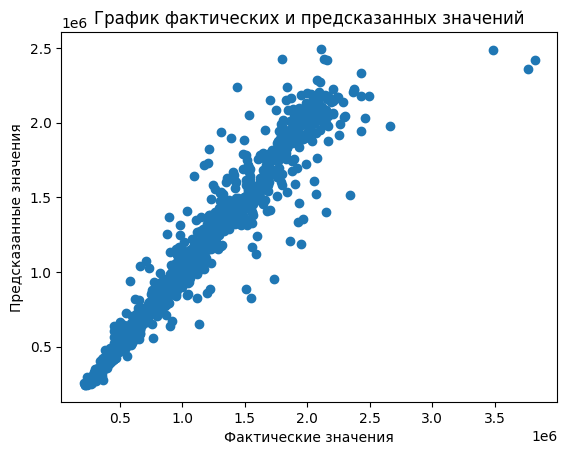

In [49]:
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('График фактических и предсказанных значений')
plt.show()

График показывает положительную корреляция между фактическими и предсказанными значениями, что показывает правильность предсказания модели

In [43]:
# Сохранение модели в файл
joblib.dump(grid_search.best_estimator_, 'trained_model.joblib')

# Загрузка модели из файла
loaded_model = joblib.load('trained_model.joblib')